In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA', 
#                'RTL', 
#                'GATE'
              ]

# Applications

## Remove DC component from complex signal

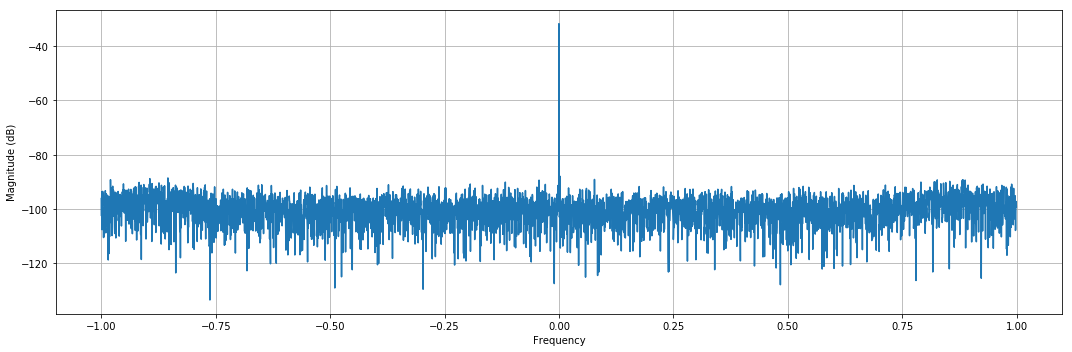

In [3]:
from data import load_iq
file = '/home/gaspar/git/pyhacores/data/bladerf_noisedc_20M.raw'
input_signal = load_iq(file)
input_signal = input_signal[:1024*4]
plt.magnitude_spectrum(input_signal, window=plt.mlab.window_none, scale='dB')
show_plot()

In [4]:
# NBVAL_IGNORE_OUTPUT
from pyhacores import DCRemoval
dut = DCRemoval(window_len=128, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 4097/4097 [00:00<00:00, 8452.41it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


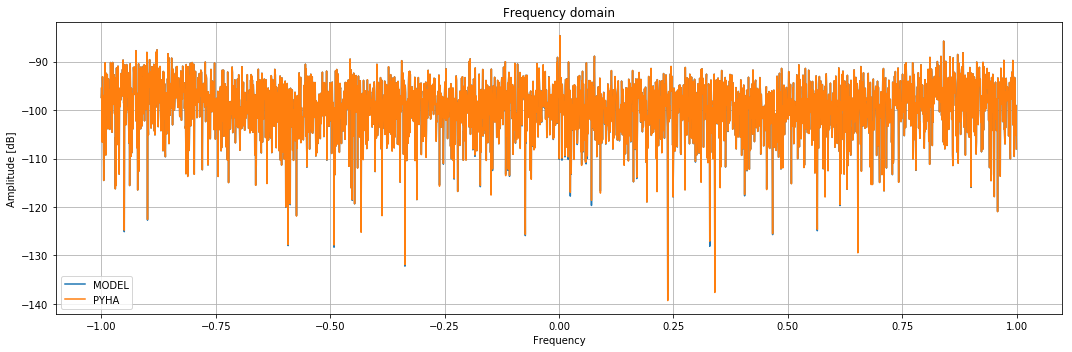

In [5]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value)[1024:], window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [6]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Selection of ``window_len``
Optimal `window_len` depends on the sample rate. Too small length can result in messed up spectrum. Usually 256 is a good value and is tested up to 80M sample rate. `window_len` controls the BRAM usage.

# Synthesis

In [7]:
# NBVAL_IGNORE_OUTPUT
output_dir = '/tmp/pyha_output'
sims = simulate(dut, input_signal[:1024], simulations=['PYHA', 'GATE'], conversion_path=output_dir)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1025/1025 [00:00<00:00, 1910.19it/s]

INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:MovingAverage to VHDL ...


INFO:conversion:DCRemoval to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Wed Aug  1 13:08:04 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 522
INFO:sim:    Total combinational functions : 486
INFO:sim:    Dedicated logic registers : 302
INFO:sim:Total registers : 302
INFO:sim:Total pins : 74
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 18,108
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:VHDL stderr: 
    loading VPI module '/home/gaspar/git/pyha/cocotb/build/libs/x86_64/libvpi.so'
    VPI module loaded!
INFO:sim:OK!
INFO:sim:Simulations completed!


In [8]:
assert hardware_sims_equal(sims)

INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:GATE OK!


In [9]:
from pyha.simulation.vhdl_simulation import VHDLSimulation
print(f'Logic elements: {VHDLSimulation.last_logic_elements}')
print(f'Memory: {VHDLSimulation.last_memory_bits}')
print(f'Multipler (9bit): {VHDLSimulation.last_multiplier}')

Logic elements: 522
Memory: 18108
Multipler (9bit): 0
